In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

In [2]:
class Room():

    def __init__(self, m, n):
        
        self.xmax = m
        self.ymax = n
        self.hx = 0.1
        self.hy = 0.1
        self.ht = 0.001
        self.xdim = int(self.xmax/self.hx)
        self.ydim = int(self.ymax/self.hy)
        self.mn = self.xdim*self.ydim
        self.room = np.empty(shape = (self.ydim,self.xdim))
        self.windows = None
        self.heaters = None
        self.walls = None
        self.doors = None
        self.alpha = 0.026
        self.Dx = (np.diag(np.ones(self.xdim - 1), -1) + np.diag(np.ones(self.xdim - 1), 1) + np.diag(-2*np.ones(self.xdim)))/(self.hx**2)
        self.Dy = (np.diag(np.ones(self.ydim - 1), -1) + np.diag(np.ones(self.ydim - 1), 1) + np.diag(-2*np.ones(self.ydim)))/(self.hy**2)
        self.Lapl = np.kron(np.identity(self.ydim), self.Dx) + np.kron(self.Dy, np.identity(self.xdim))
        self.power = 1006
        self.rho = 1.2
        self.A = 0.6*0.6*0.1
        self.cp = 1005
        self.H = self.power/(self.rho*self.A*self.cp)
        self.threshold = 273+18
        self.avg_temp = None
        self.t_out = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Mod Det/Projekt/daily_temp.pkl')
        self.curr_t = 0
        self.t_ind = int(np.floor(self.curr_t))
        self.Tout = self.t_out.loc[self.t_ind, 'Temp']
        self.room_scheme = np.empty(shape = (self.ydim,self.xdim))
        self.energy_cost = 0

    def get_walls_ind(self):
        walls_temp = np.arange(self.mn)
        left_wall = walls_temp[walls_temp  % self.xdim == 0]
        right_wall = left_wall + self.xdim - 1
        upper_wall = walls_temp[0:self.xdim]
        lower_wall = walls_temp[-self.xdim:]
        self.walls = {'lw':left_wall, 'rw':right_wall, 'uw':upper_wall, 'low':lower_wall}   

    def init_ic(self, temp_init = 18):
        self.room[:, :] = 273 + temp_init
        
    def act_tind(self):
        self.t_ind = int(np.floor(self.curr_t))

    def act_tout(self):
        self.Tout = self.t_out.loc[self.t_ind, 'Temp']
    
    def plot_room(self):
        plt.imshow(self.room, extent=(0, self.xmax, 0, self.ymax), origin='lower', cmap='viridis')
        plt.colorbar(label="Temperature")
        plt.show()

    def make_scheme(self):
        room_scheme = self.room_scheme.flatten()
        room_scheme[:] = 0
        room_scheme[self.walls['lw']] = 100
        room_scheme[self.walls['rw']] = 100
        room_scheme[self.walls['uw']] = 100
        room_scheme[self.walls['low']] = 100
        room_scheme[self.heaters] = 150
        room_scheme[self.windows] = 200
        room_scheme[self.doors] = 250
        self.room_scheme = room_scheme.reshape(self.ydim, self.xdim)

    def plot_scheme(self):
        plt.imshow(self.room_scheme, extent=(0, self.xmax, 0, self.ymax), origin='lower', cmap='viridis')
        plt.colorbar(label="Scheme")
        plt.show()

    def solve(self):
        
        u = self.room.flatten()      
        self.avg_temp = np.mean(u)
        Lu = np.matmul(self.Lapl, u)
        v = self.alpha*Lu*self.ht + u

        v[self.walls['lw']] = v[(self.walls['lw'])+1]
        v[self.walls['rw']] = v[(self.walls['rw'])-1]
        v[self.walls['uw']] = v[(self.walls['uw']) + self.xdim]
        v[self.walls['low']] = v[(self.walls['low']) - self.xdim]
        v[self.windows] = self.Tout
        if self.avg_temp < self.threshold:
            energy_used = self.ht*self.H*np.ones(len(self.heaters))
            v[self.heaters] = v[self.heaters] + energy_used
            self.energy_cost = self.energy_cost + np.sum(energy_used*self.hx)
        
        self.room = v.reshape(self.ydim, self.xdim)

In [85]:
class Home():

    def __init__(self, T):

        self.rooms = []
        self.T = T
        self.home = None
        self.home_scheme = None
        self.curr_t = 0
        self.cost_fun = None
        self.N = None
        self.ht = 0.001
        self.xmax = None
        self.ymax = None
        self.avg_temp = None
        self.energy_used = 0

    def load_rooms(self, size, n, xdim, ydim):
        for i in range(n):
            curr_size = size[i]
            room = Room(curr_size[0], curr_size[1])
            self.rooms.append(room)
        self.N = n
        self.xmax = xdim
        self.ymax = ydim

    def create_home(self):
        v = self.rooms[0].room
        u = self.rooms[1].room
        v = np.hstack((v,u))
        u = self.rooms[2].room
        v = np.hstack((v,u))
        u = self.rooms[3].room
        v = np.vstack((u,v))
        self.home = v

    def room_setup(self, w, d, h, i):
        self.rooms[i].get_walls_ind()
        self.rooms[i].init_ic()
        self.rooms[i].windows = w
        self.rooms[i].doors = d
        self.rooms[i].heaters = h
        self.rooms[i].make_scheme()
        
    def make_home_scheme(self):
        v = self.rooms[0].room_scheme
        u = self.rooms[1].room_scheme
        v = np.hstack((v,u))
        u = self.rooms[2].room_scheme
        v = np.hstack((v,u))
        u = self.rooms[3].room_scheme
        v = np.vstack((u,v))
        self.home_scheme = v

    def plot_home_scheme(self):
        plt.imshow(self.home_scheme, extent=(0, 100, 0, 60), origin='lower', cmap='viridis')
        plt.colorbar(label="Scheme")
        plt.show()  

    def plot_home(self):
        plt.imshow(self.home, extent=(0, self.xmax, 0, self.ymax), origin='lower', cmap='viridis', vmin = 273+7, vmax = 273+36)
        #plt.colorbar(label="Temperature")
        cbar = plt.colorbar(label="Temperature [°C]")
        def kelvin_to_celsius(val, pos):
            return round(val - 273.15, 2)
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(kelvin_to_celsius))
        plt.show()

    def calc_doors(self, i):
        r1 = self.rooms[i].room.flatten()
        r2 = self.rooms[3].room.flatten()
        temp_door = np.append(r1[self.rooms[i].doors], r2[self.rooms[3].doors[10*i:(10*(i+1))]])
        door_mean = np.mean(temp_door)
        r1[self.rooms[i].doors] = door_mean
        r2[self.rooms[3].doors[10*i:(10*(i+1))]] = door_mean
        self.rooms[i].room = r1.reshape(self.rooms[i].ydim, self.rooms[i].xdim)
        self.rooms[3].room = r2.reshape(self.rooms[3].ydim, self.rooms[3].xdim)

    def update_cost(self):
        en = 0
        for i in range(self.N):
            en = en +self.rooms[i].energy_cost
        self.energy_used = en
            
    def evolve(self):

        for i in range(self.N):
            self.rooms[i].curr_t = self.curr_t
            self.rooms[i].act_tind()
            self.rooms[i].act_tout()
            self.rooms[i].solve()
            self.update_cost()
            
        for i in range(self.N-1):   
            self.calc_doors(i)
        
        self.curr_t = self.curr_t + self.ht
        self.create_home()

    def calc_mean_temp(self):
        u = self.home.flatten()
        self.avg_temp = np.mean(u)

In [87]:
### Room 1, 2

In [89]:
x1d = 30
y1d = 40

w_start = (y1d*x1d) - 18
w_stop = (y1d*x1d) - 12
windows1 = np.arange(w_start, w_stop)
h_stop = (y1d-1)*x1d - 12
h_start = (y1d-1)*x1d - 18
heaters1 = np.arange(h_start, h_stop)
doors1 = np.arange(10,20)

In [91]:
### Room3

In [93]:
x1d = 40
y1d = 40

w_start = (y1d*x1d) - 23
w_stop = (y1d*x1d) - 17
windows2 = np.arange(w_start, w_stop)
h_stop = (y1d-1)*x1d - 17
h_start = (y1d-1)*x1d - 23
heaters2 = np.arange(h_start, h_stop)
doors2 = np.arange(15,25)

In [95]:
### Room 4

In [97]:
x1d = 100
y1d = 20

windows3 = np.append(np.arange(32,38), np.arange(62,68))
doors3 = np.append(np.append(np.arange(10,20)+(x1d*(y1d-1)), np.arange(40,50)+(x1d*(y1d-1))), np.arange(75,85)+(x1d*(y1d-1)))
heaters3 = np.append(np.arange(32,38) + x1d, np.arange(62,68) + x1d)

In [99]:
## Home 2

In [101]:
### Room 1, 2, 3

In [103]:
x1d = 30
y1d = 40

h_start = x1d*17
h_stop = x1d*23

heatersb1 = np.arange(h_start + 1, h_stop + 1, x1d)

In [105]:
### Room 3

In [107]:
x1d = 40
y1d = 40

h_start = x1d*17
h_stop = x1d*23

heatersb2 = np.arange(h_start + 1, h_stop + 1, x1d)

In [109]:
### Room 4

In [111]:
x1d = 100
y1d = 20

h1 = np.arange(7*x1d + 1, 13*x1d + 1, x1d)
h2 = h1 + x1d - 3
heatersb3 = np.append(h1, h2)

In [113]:
## Home 3

In [115]:
### Rooms 1, 2

In [117]:
x1d = 30
y1d = 40

h_stop = (y1d-1)*x1d - 15 + 2
h_start = (y1d-1)*x1d - 18 + 2
hc1 = np.arange(h_start, h_stop)
hc2 = hc1 - x1d
heatersc1 = np.append(hc1, hc2)

In [119]:
### Room3

In [121]:
x1d = 40
y1d = 40

h_stop = (y1d-1)*x1d - 20 + 2
h_start = (y1d-1)*x1d - 23 + 2
hc1 = np.arange(h_start, h_stop)
hc2 = hc1 - x1d
heatersc2 = np.append(hc1, hc2)

In [123]:
### Room4

In [125]:
x1d = 100
y1d = 20

hc1 = np.append(np.arange(35,38) + x1d - 2, np.arange(65,68) + x1d - 2)
hc2 = hc1 + x1d
heatersc3 = np.append(hc1, hc2)

In [129]:
home = Home(10)
sizes = [[3,4], [3, 4], [4, 4], [10, 2]]
home.load_rooms(sizes, 4, 10, 6)

In [131]:
home.room_setup(windows1, doors1, heaters1, 0)
home.room_setup(windows1, doors1, heaters1, 1)
home.room_setup(windows2, doors2, heaters2, 2)
home.room_setup(windows3, doors3, heaters3, 3)

In [133]:
home.rooms[0].init_ic(17.5)
home.rooms[2].init_ic(17.7)
home.rooms[3].init_ic(17.9)

In [135]:
home.make_home_scheme()

In [137]:
home.create_home()

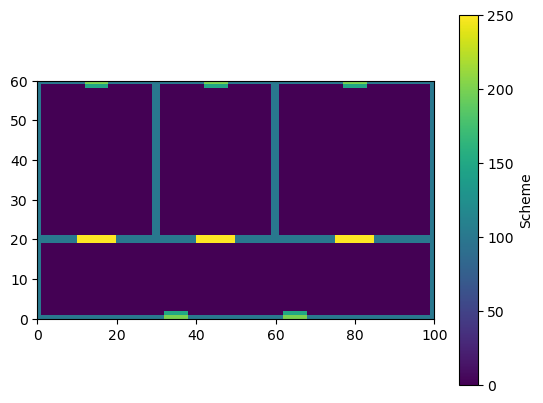

In [139]:
home.plot_home_scheme()

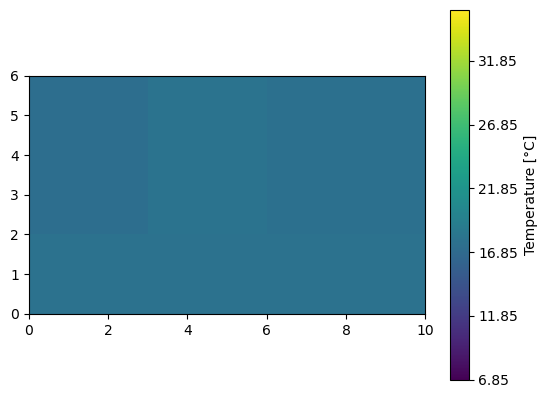

In [141]:
home.plot_home()

In [143]:
mean_temps = []

In [145]:
j = 0

Hour no 0

Mean temp 17.74456505369517


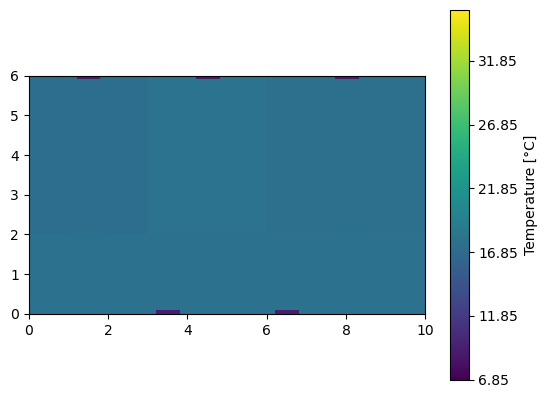

Hour no 1000

Mean temp 17.747402634425384


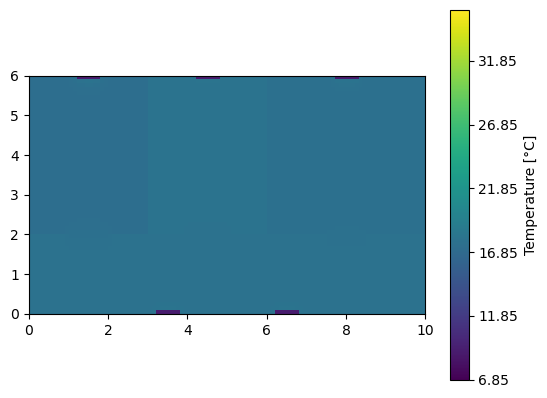

Hour no 2000

Mean temp 17.748426157977462


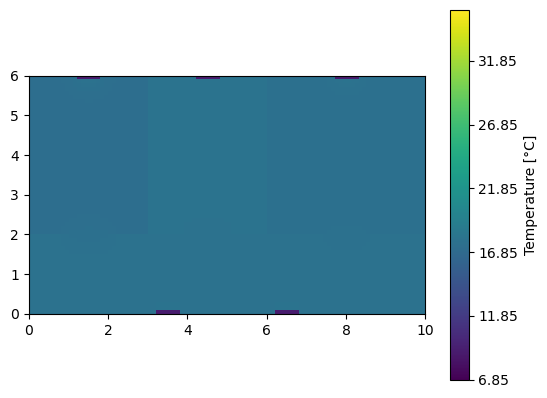

Hour no 3000

Mean temp 17.747439945268695


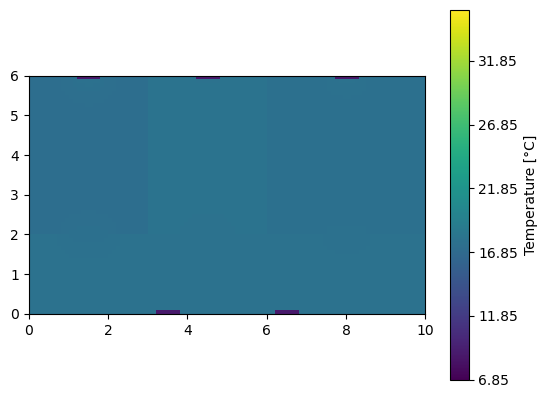

Hour no 4000

Mean temp 17.745976777859426


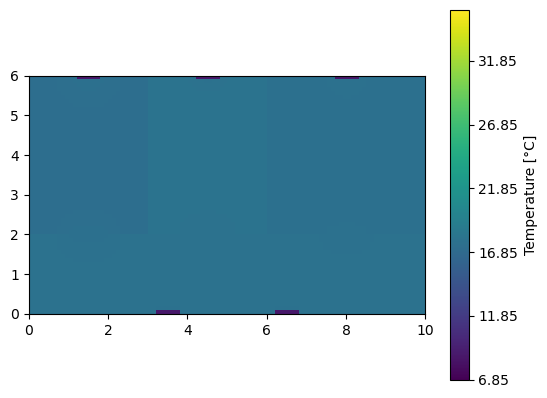

Hour no 5000

Mean temp 17.745348759238766


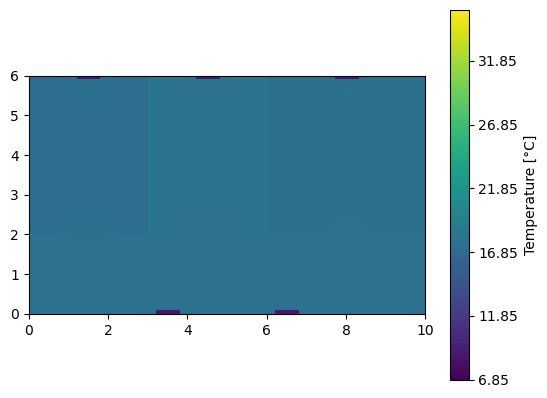

Hour no 6000

Mean temp 17.748501166855476


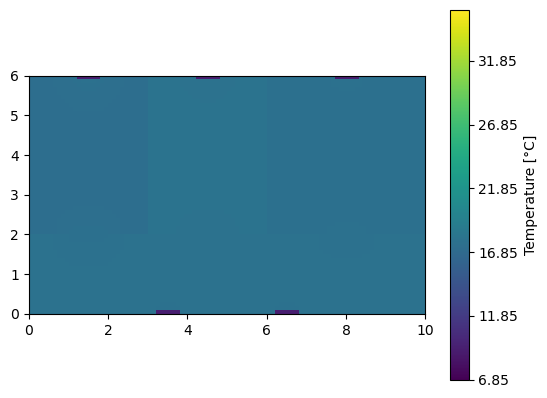

Hour no 7000

Mean temp 17.75705825814515


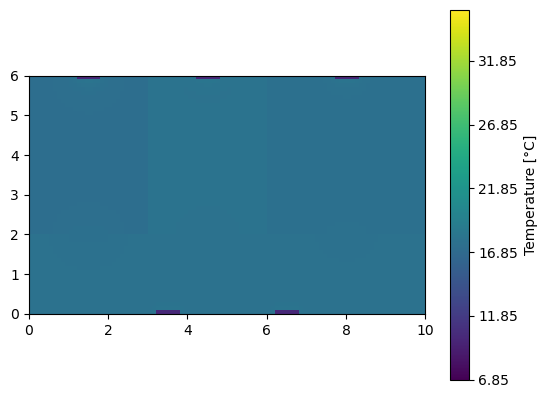

Hour no 8000

Mean temp 17.77170154316616


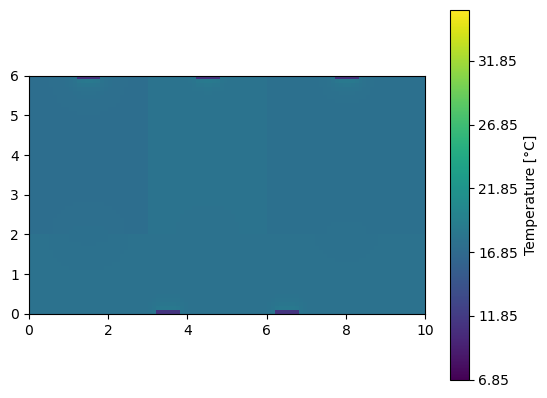

Hour no 9000

Mean temp 17.792443240446346


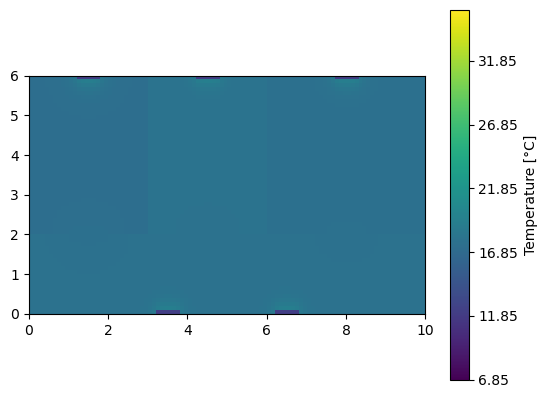

Hour no 10000

Mean temp 17.81036525622278


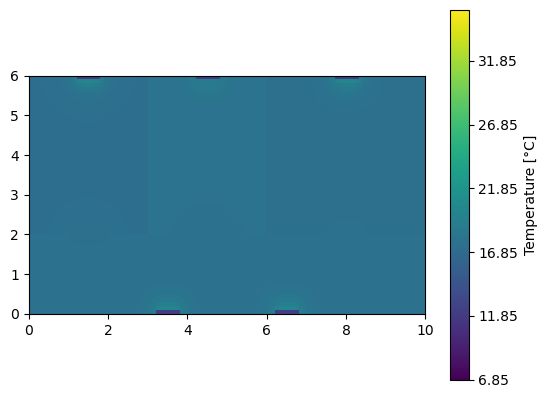

Hour no 11000

Mean temp 17.834134073272367


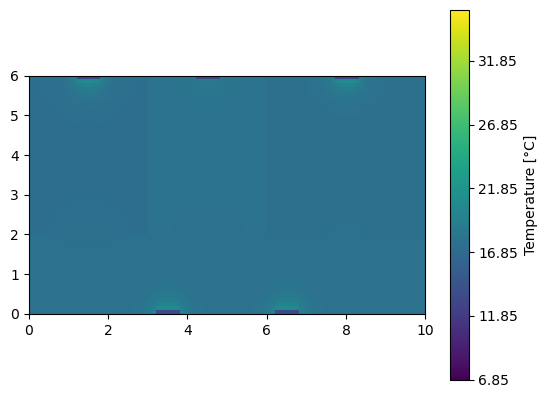

Hour no 12000

Mean temp 17.859306028791366


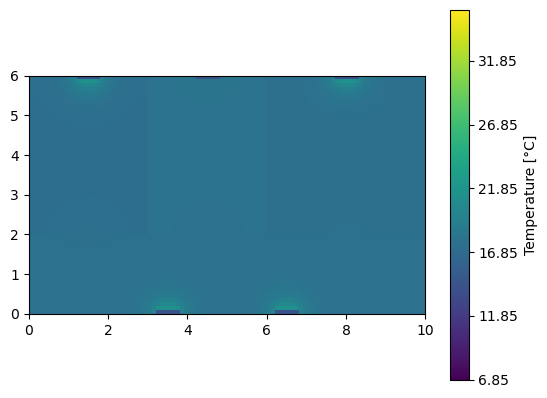

Hour no 13000

Mean temp 17.877122304998863


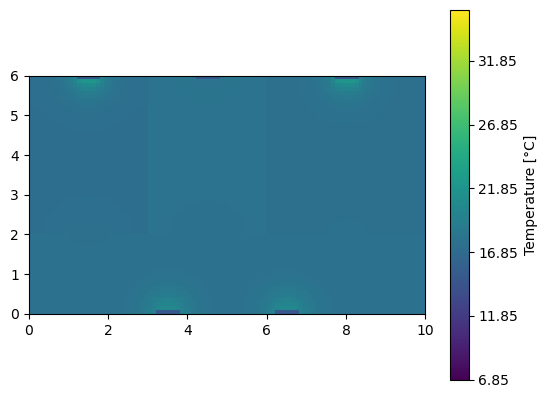

Hour no 14000

Mean temp 17.88970288630054


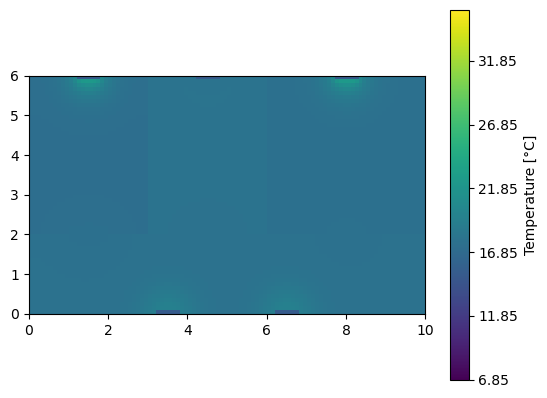

Hour no 15000

Mean temp 17.90115782491182


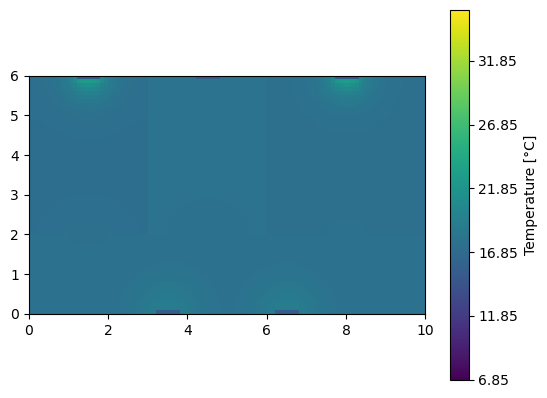

Hour no 16000

Mean temp 17.91050411294401


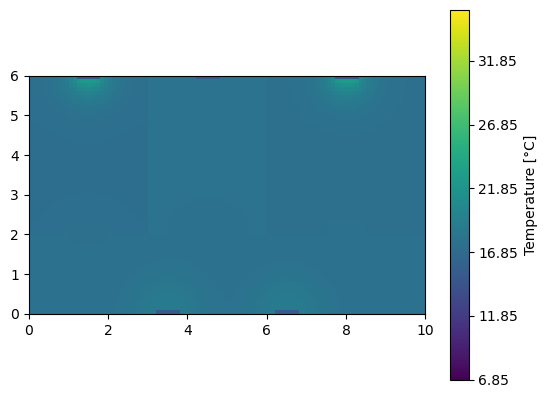

Hour no 17000

Mean temp 17.916846858703252


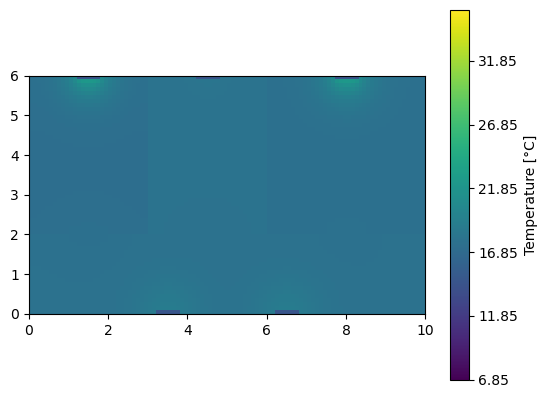

Hour no 18000

Mean temp 17.920119632755643


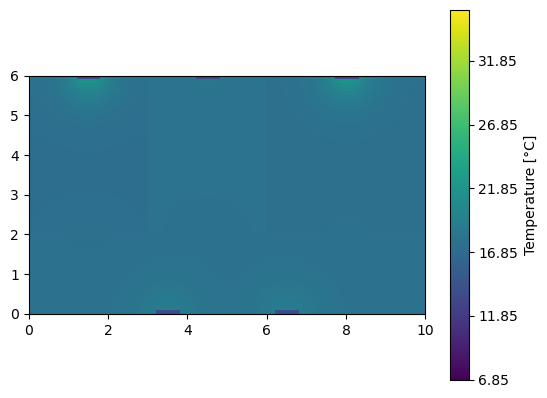

Hour no 19000

Mean temp 17.915526433757066


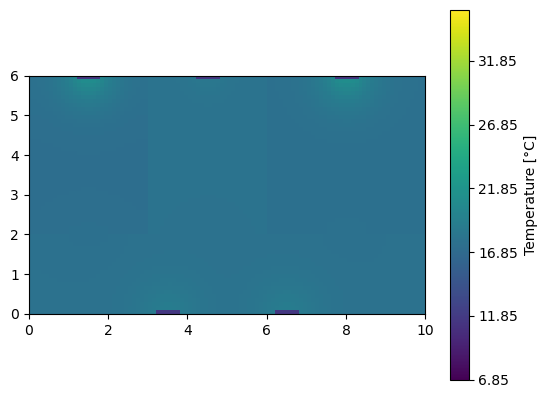

Hour no 20000

Mean temp 17.91546138034238


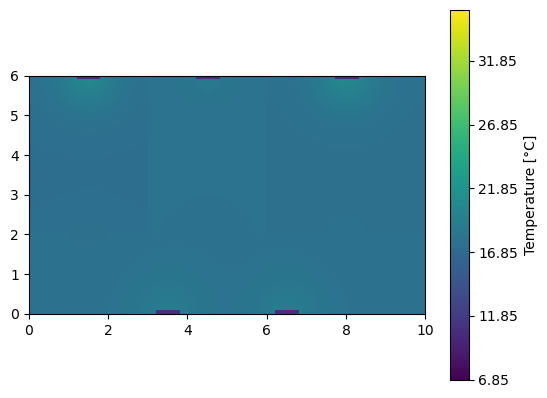

Hour no 21000

Mean temp 17.914719870961335


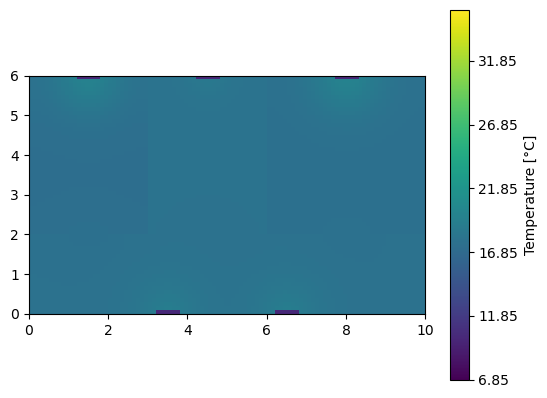

Hour no 22000

Mean temp 17.91321268376538


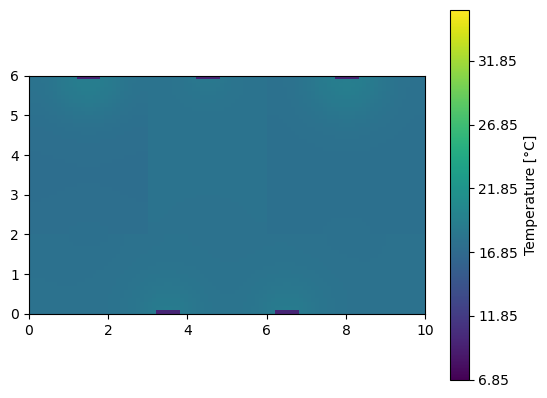

Hour no 23000

Mean temp 17.91051458541409


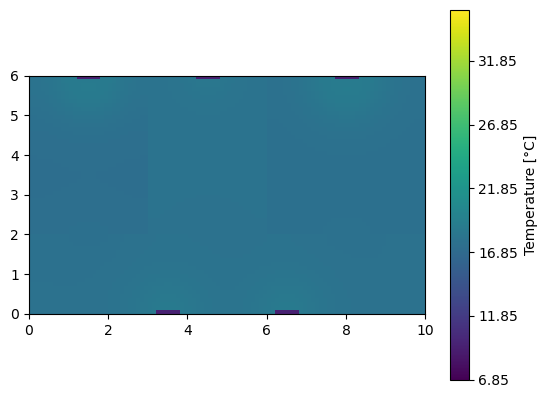

In [147]:
for i in range(24000 - 1):
    home.evolve()
    home.calc_mean_temp()
    mean_temps.append(home.avg_temp)
    if i%1000 == 0:
        print(f'Hour no {i}\n')
        print(f'Mean temp {home.avg_temp - 273}')
        home.plot_home()
        j = j + 1

In [194]:
mean_temps = np.array(mean_temps) - 273

In [208]:
def mean_temp_plot(data):
    tick_positions = np.linspace(0, 24000, 25)[:-1]
    tick_labels = [f"{h:02d}:00" for h in range(24)] 
    plt.plot(np.arange(24000 - 1), data)
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.yticks(np.round(np.linspace(min(data), max(data), 6), 2)) 
    plt.title('Srednie temperatury w domu')
    plt.xlabel('Godzina')
    plt.ylabel('Temperatura')
    plt.show()

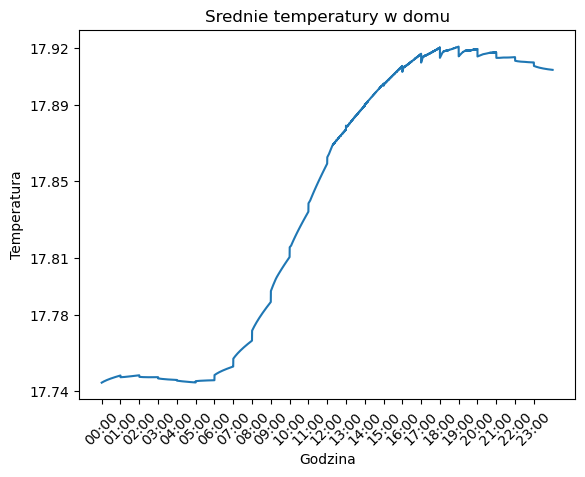

In [210]:
mean_temp_plot(mean_temps)

In [212]:
home.energy_used

1507.707048093225

In [215]:
home2 =  Home(10)
sizes = [[3,4], [3, 4], [4, 4], [10, 2]]
home2.load_rooms(sizes, 4, 10, 6)
home2.create_home()

In [217]:
home2.room_setup(windows1, doors1, heatersb1, 0)
home2.room_setup(windows1, doors1, heatersb1, 1)
home2.room_setup(windows2, doors2, heatersb2, 2)
home2.room_setup(windows3, doors3, heatersb3, 3)

In [219]:
home2.make_home_scheme()

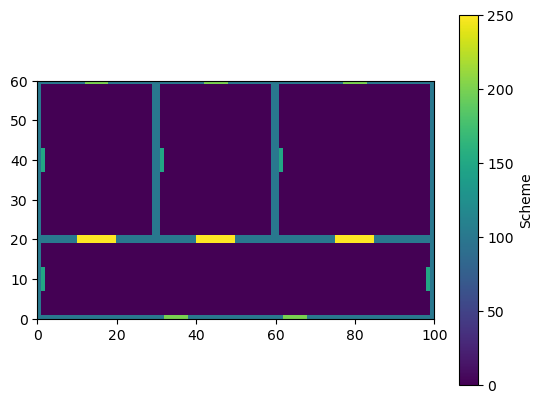

In [221]:
home2.plot_home_scheme()

In [223]:
home2.rooms[0].init_ic(17.5)
home2.rooms[2].init_ic(17.7)
home2.rooms[3].init_ic(17.9)

In [225]:
home2.create_home()

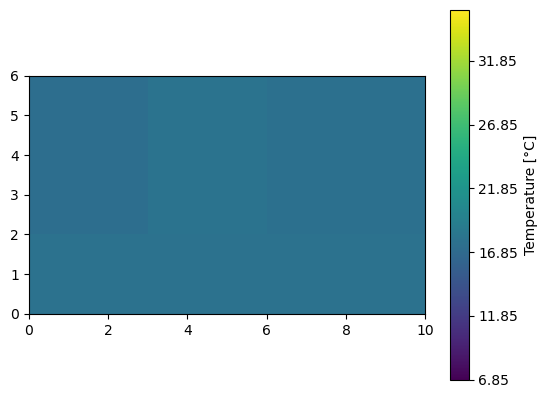

In [227]:
home2.plot_home()

Hour no 0

Mean temp 17.74456505369517


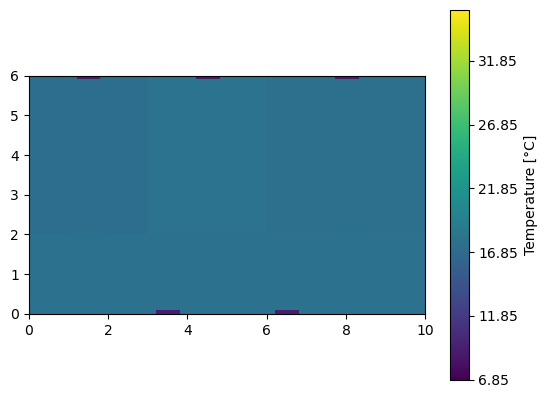

Hour no 1000

Mean temp 17.839440494044936


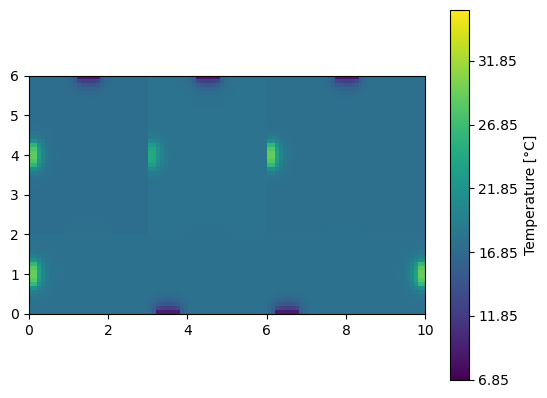

Hour no 2000

Mean temp 17.890138484556132


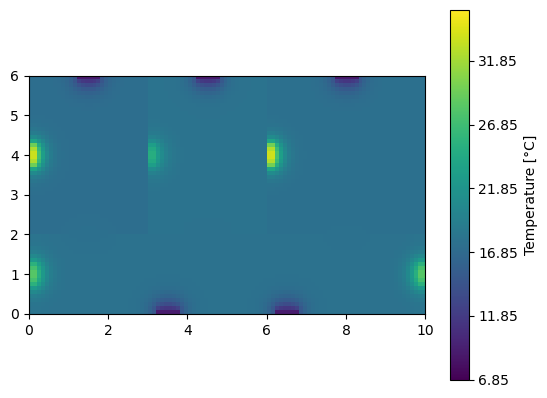

Hour no 3000

Mean temp 17.9307073889226


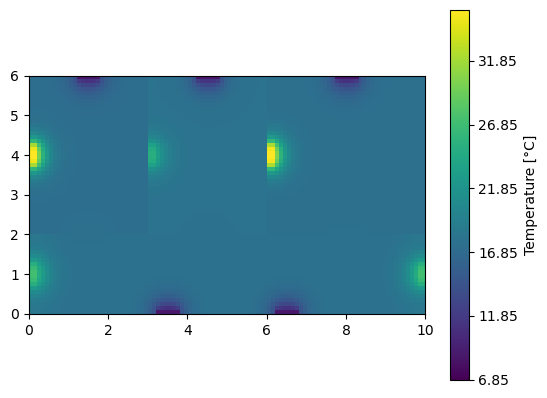

Hour no 4000

Mean temp 17.970777062339266


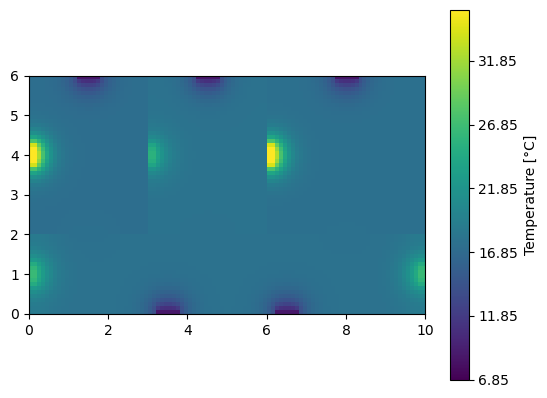

Hour no 5000

Mean temp 17.99727700045071


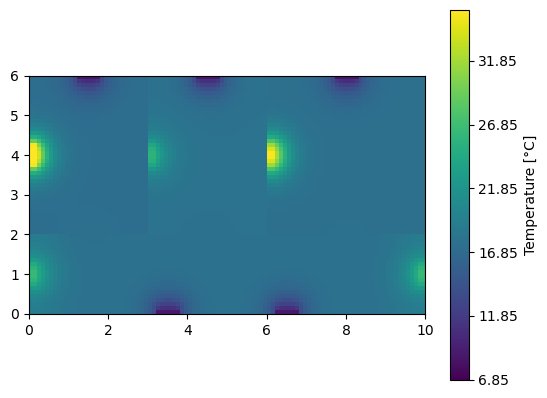

Hour no 6000

Mean temp 18.00266702005331


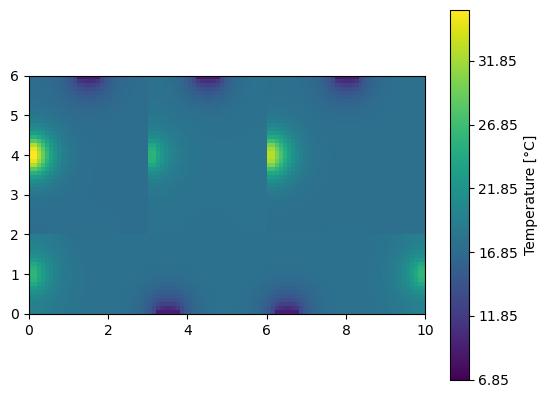

Hour no 7000

Mean temp 18.00410422083951


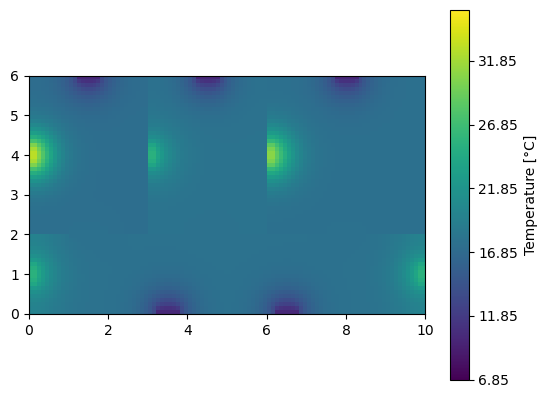

Hour no 8000

Mean temp 18.005164118085304


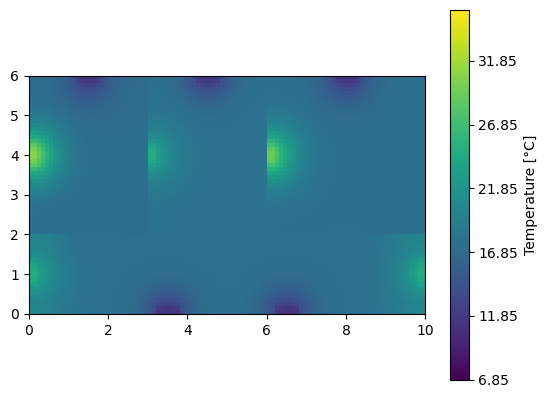

Hour no 9000

Mean temp 18.00561181672606


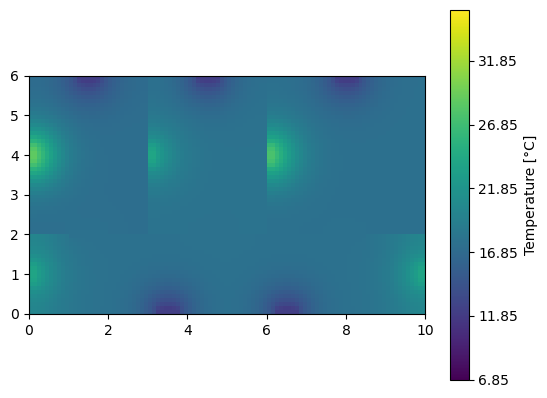

Hour no 10000

Mean temp 18.000066472355


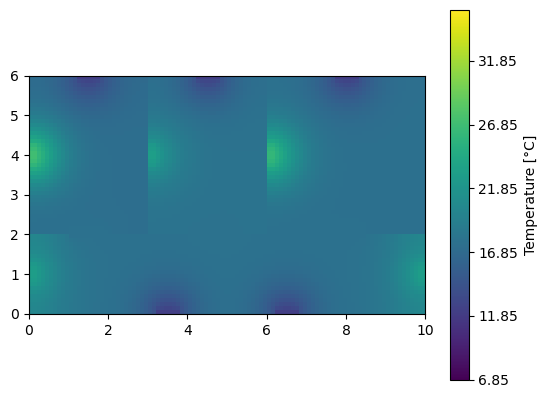

Hour no 11000

Mean temp 18.000119349403633


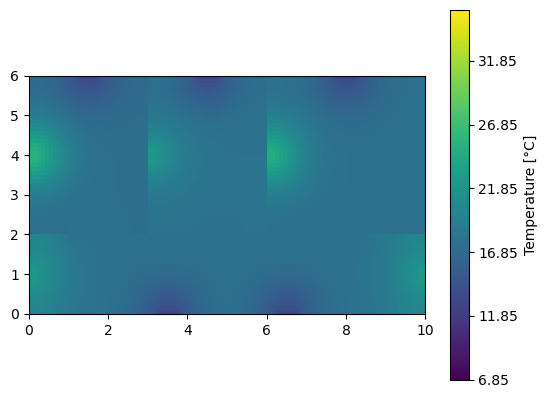

Hour no 12000

Mean temp 18.000075358511253


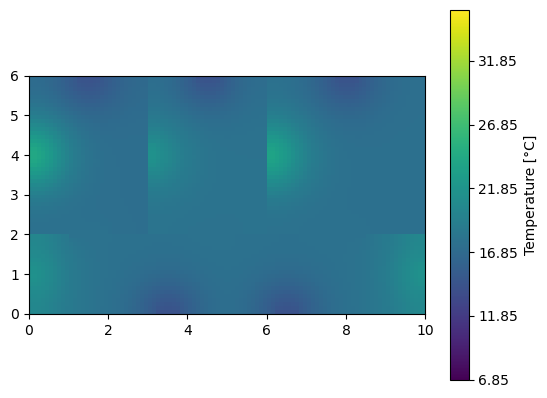

Hour no 13000

Mean temp 18.00038578699349


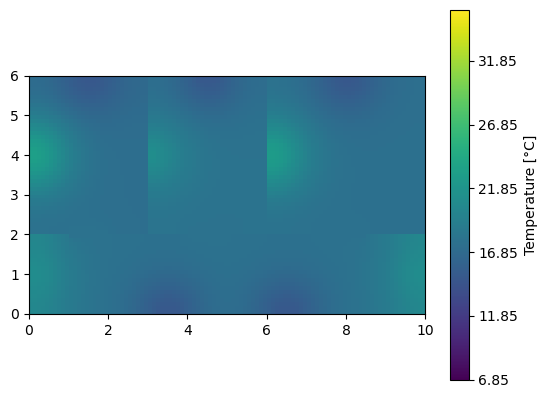

Hour no 14000

Mean temp 18.00079045715802


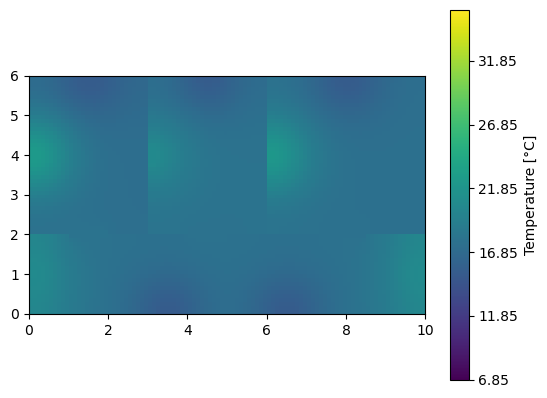

Hour no 15000

Mean temp 18.000398014158748


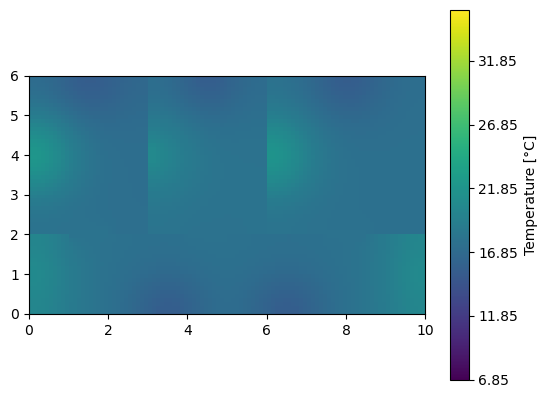

Hour no 16000

Mean temp 18.000075496190277


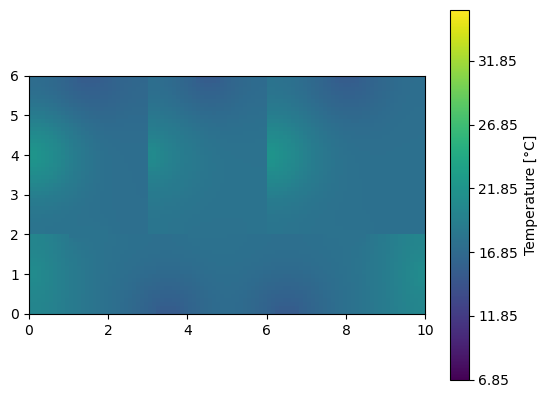

Hour no 17000

Mean temp 18.00009664405104


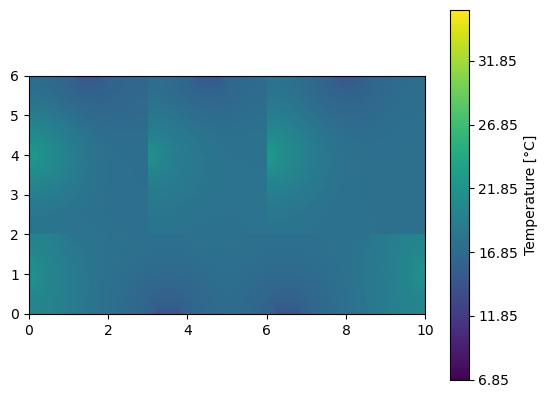

Hour no 18000

Mean temp 18.000102904795995


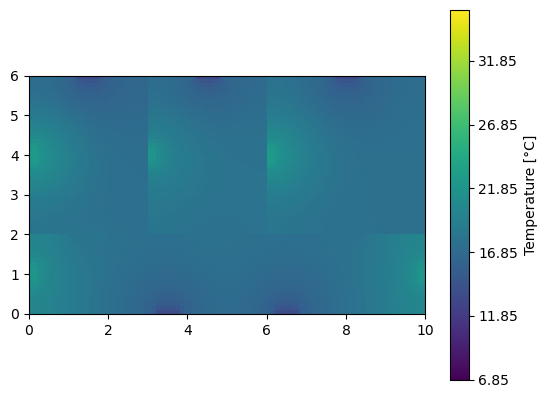

Hour no 19000

Mean temp 17.994975125259884


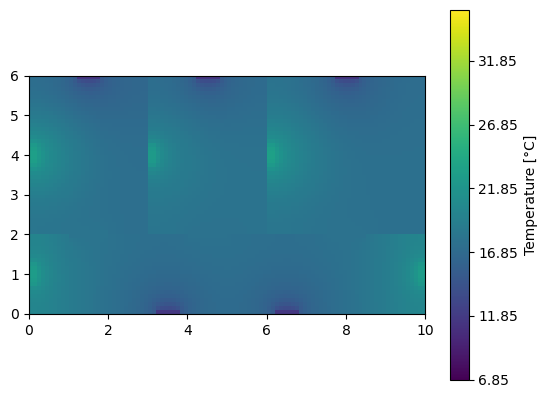

Hour no 20000

Mean temp 17.996218194929497


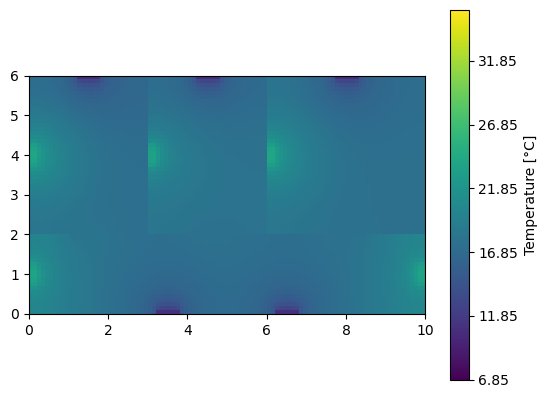

Hour no 21000

Mean temp 17.99726555220218


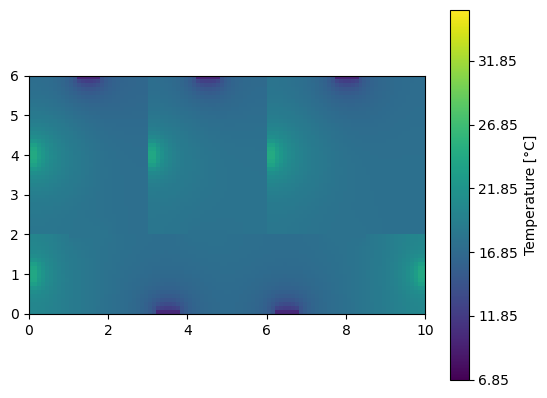

Hour no 22000

Mean temp 17.998142321046487


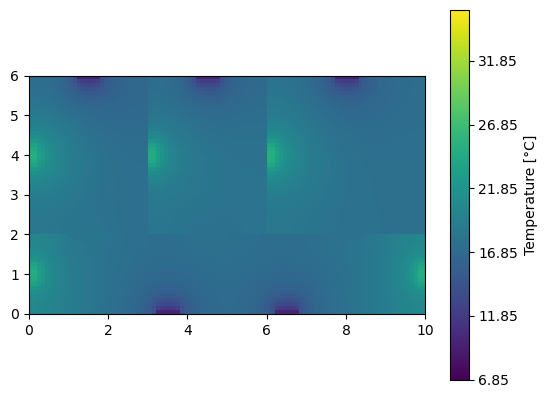

Hour no 23000

Mean temp 17.998269370202536


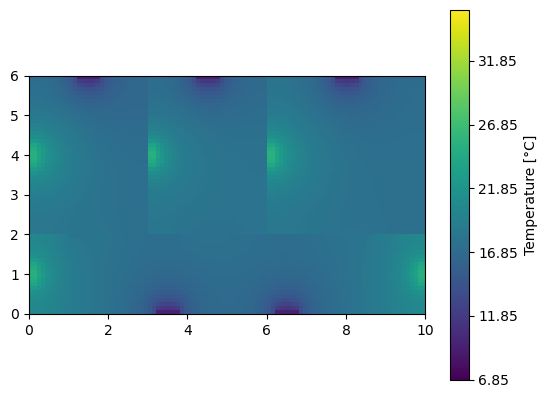

In [229]:
mean_temps2 = []

for i in range(24000 - 1):
    home2.evolve()
    home2.calc_mean_temp()
    mean_temps2.append(home2.avg_temp)
    if i%1000 == 0:
        print(f'Hour no {i}\n')
        print(f'Mean temp {home2.avg_temp - 273}')
        home2.plot_home()
        j = j + 1

In [233]:
mean_temps2 = np.array(mean_temps2) - 273

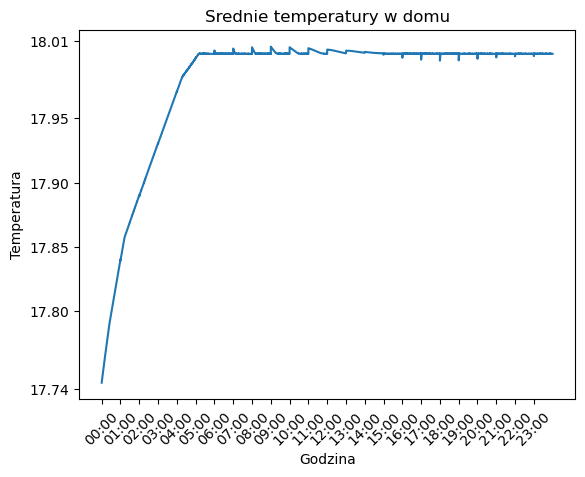

In [237]:
mean_temp_plot(mean_temps2)

In [231]:
home2.energy_used

406.9322830292824

In [239]:
home3 = Home(10)
sizes = [[3,4], [3, 4], [4, 4], [10, 2]]
home3.load_rooms(sizes, 4, 10, 6)
home3.create_home()

In [241]:
home3.room_setup(windows1, doors1, heatersc1, 0)
home3.room_setup(windows1, doors1, heatersc1, 1)
home3.room_setup(windows2, doors2, heatersc2, 2)
home3.room_setup(windows3, doors3, heatersc3, 3)

In [243]:
home3.make_home_scheme()

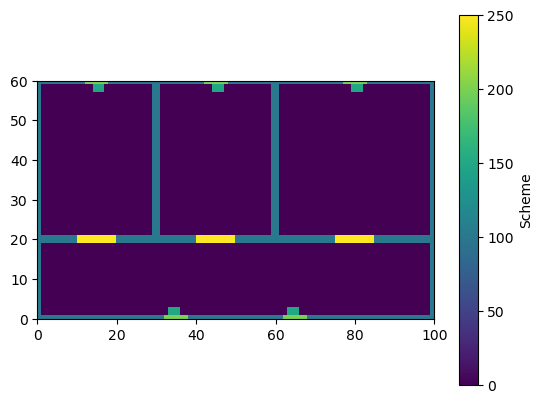

In [245]:
home3.plot_home_scheme()

In [247]:
home3.rooms[0].init_ic(17.5)
home3.rooms[2].init_ic(17.7)
home3.rooms[3].init_ic(17.9)

Hour no 0

Mean temp 17.74456505369517


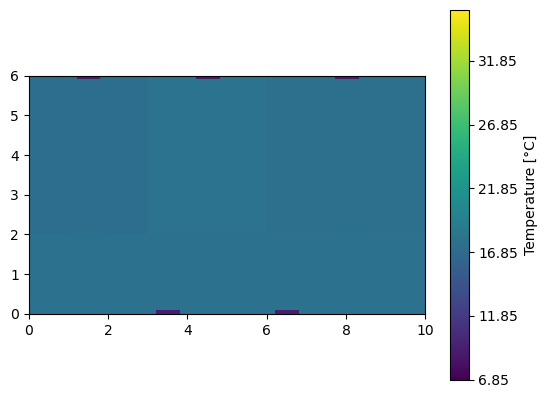

Hour no 1000

Mean temp 17.75612827733937


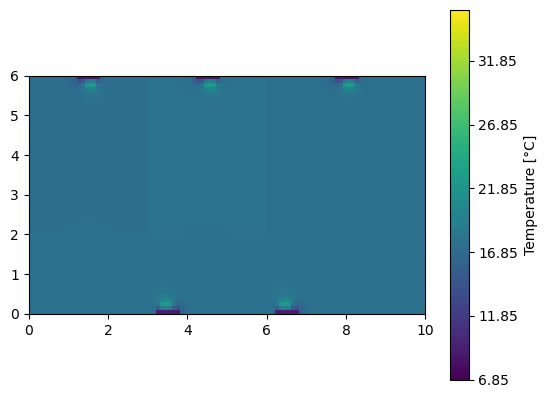

Hour no 2000

Mean temp 17.76645559187915


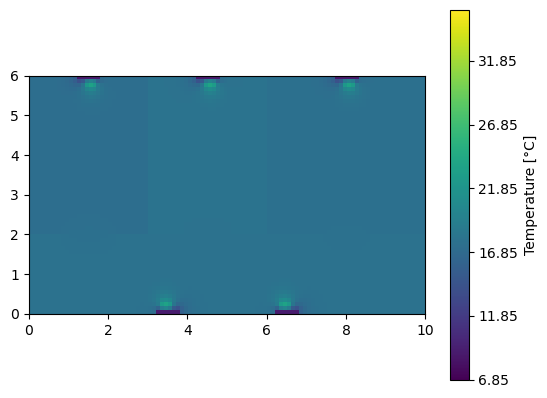

Hour no 3000

Mean temp 17.7737960922326


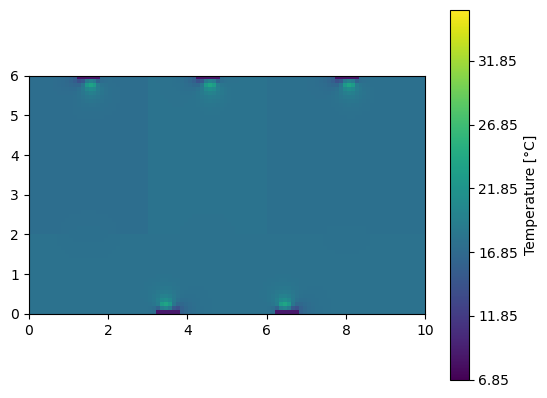

Hour no 4000

Mean temp 17.780030165393953


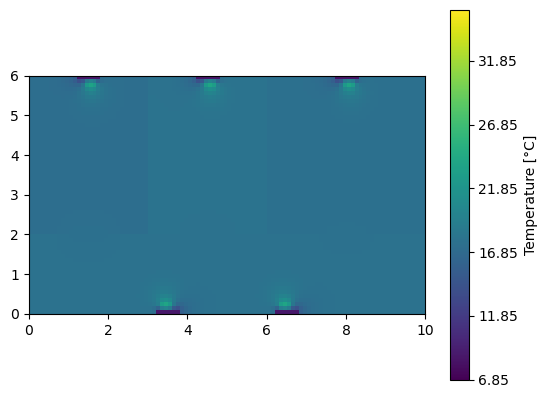

Hour no 5000

Mean temp 17.786669360825385


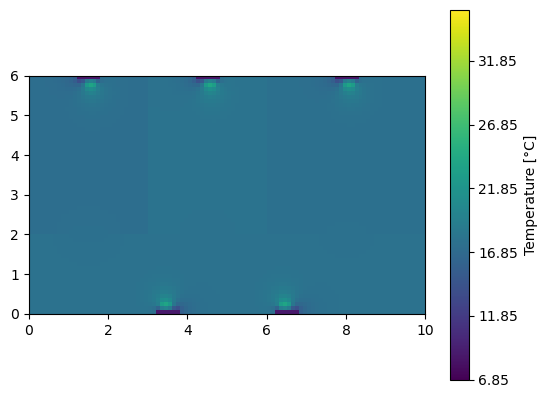

Hour no 6000

Mean temp 17.796781600510258


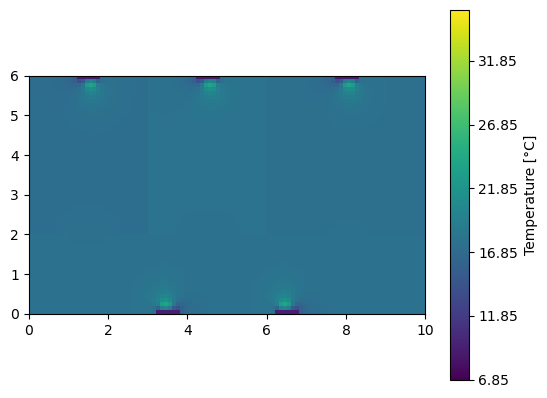

Hour no 7000

Mean temp 17.80992519089341


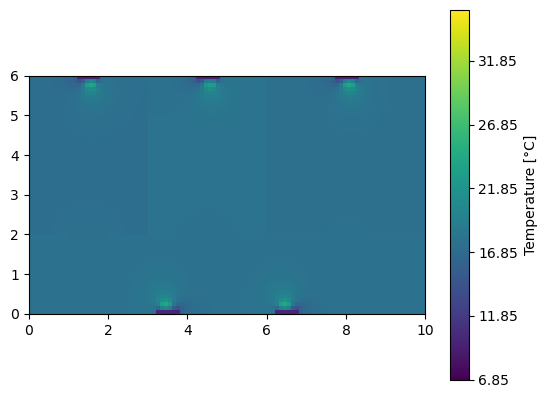

Hour no 8000

Mean temp 17.82729076170392


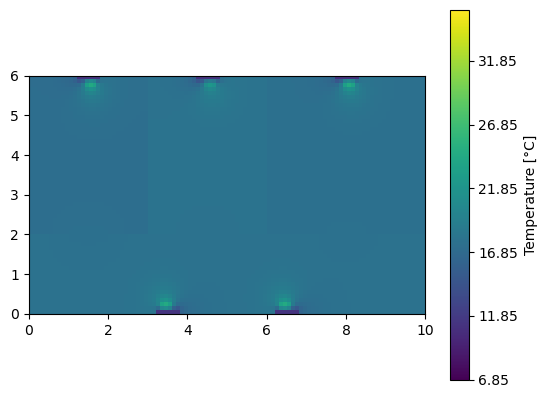

Hour no 9000

Mean temp 17.849283365345457


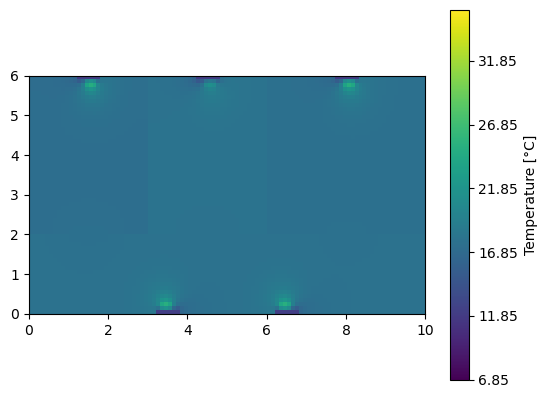

Hour no 10000

Mean temp 17.86828029193373


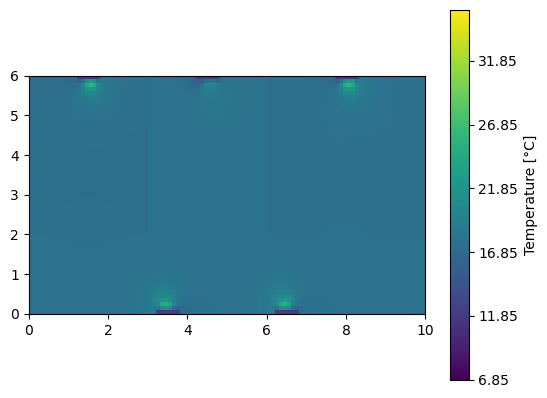

Hour no 11000

Mean temp 17.883084076053024


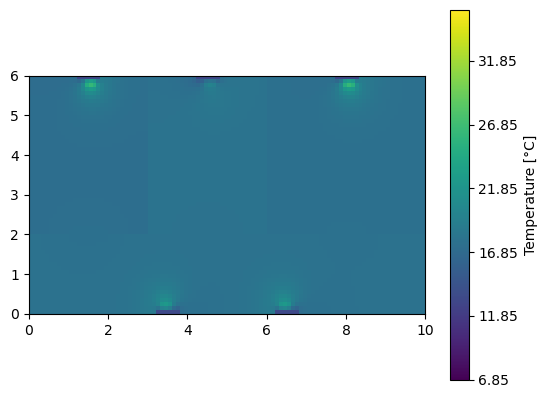

Hour no 12000

Mean temp 17.898548135858903


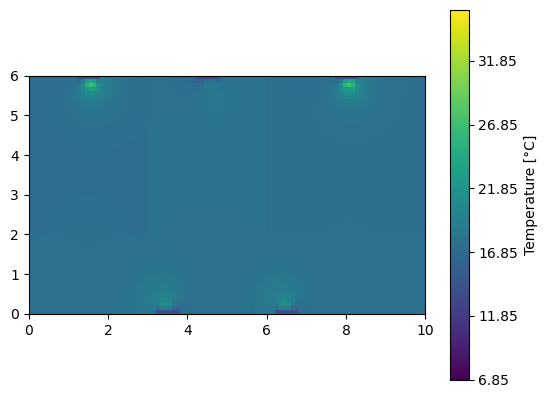

Hour no 13000

Mean temp 17.914072534708453


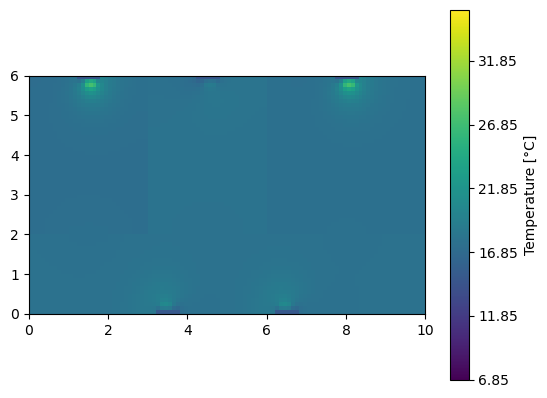

Hour no 14000

Mean temp 17.929003531871786


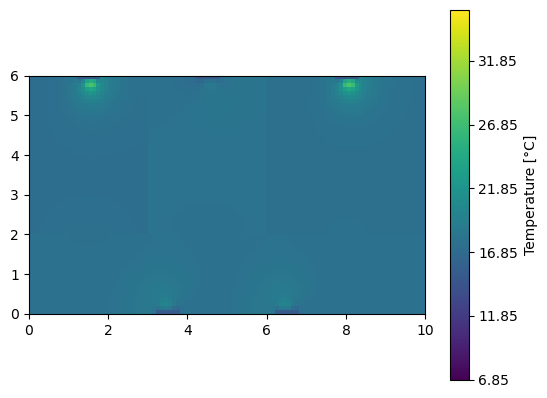

Hour no 15000

Mean temp 17.942815252552634


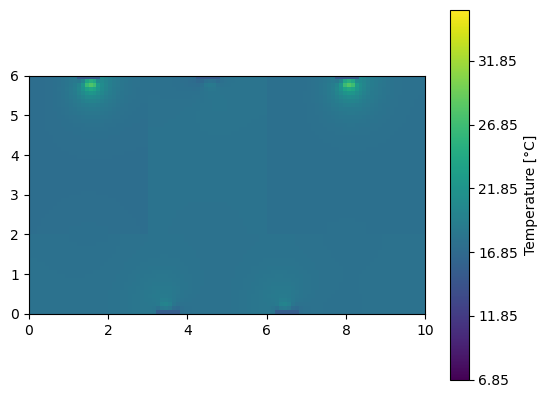

Hour no 16000

Mean temp 17.954464633984003


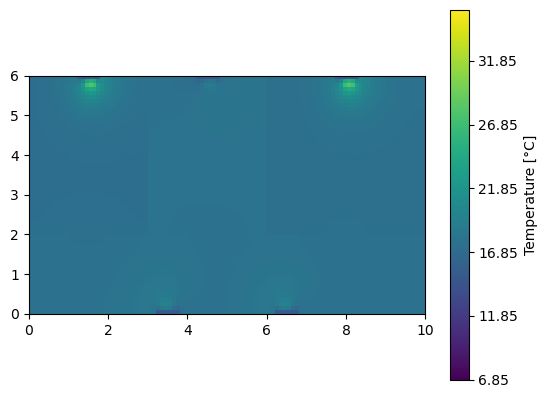

Hour no 17000

Mean temp 17.96310955239261


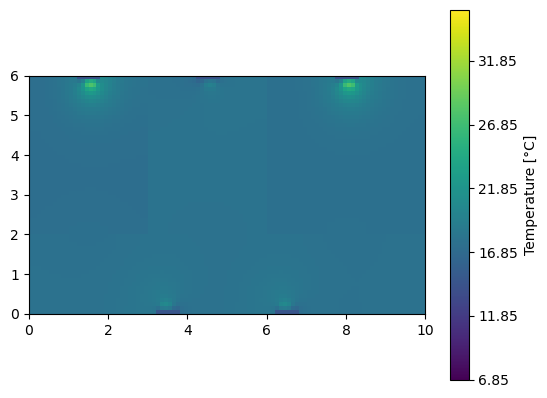

Hour no 18000

Mean temp 17.968676674291487


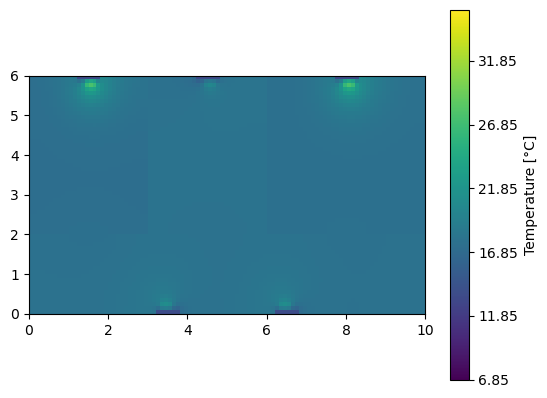

Hour no 19000

Mean temp 17.966398229631693


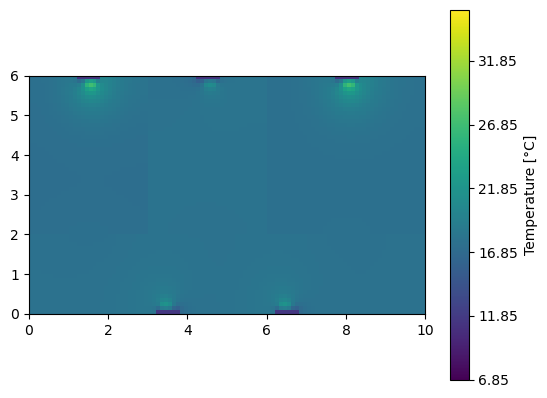

Hour no 20000

Mean temp 17.968554964268037


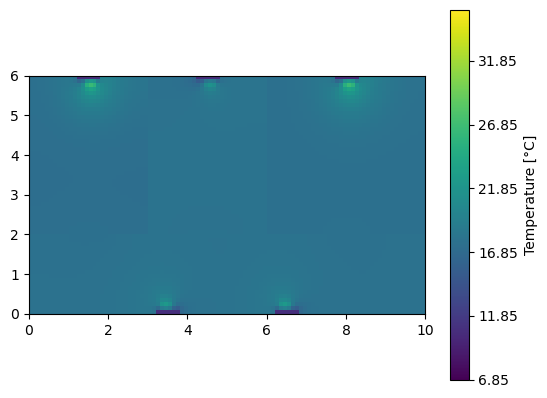

Hour no 21000

Mean temp 17.97003542375427


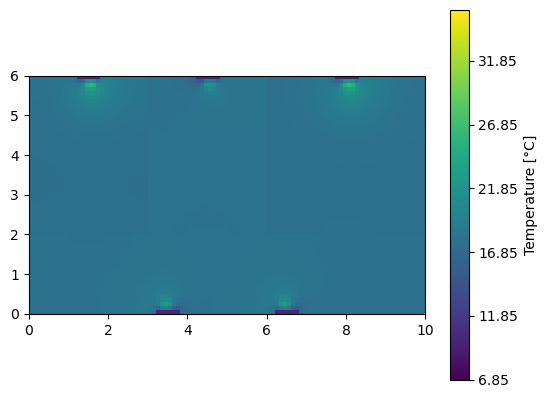

Hour no 22000

Mean temp 17.971291779443334


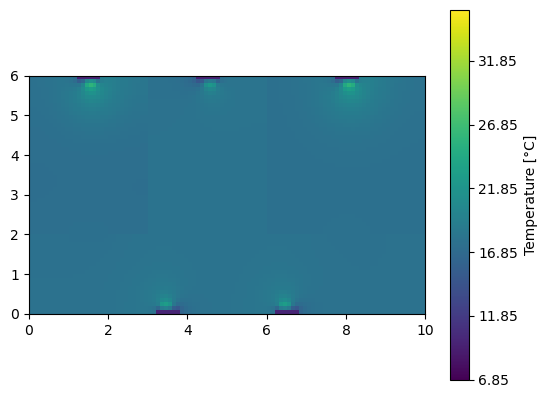

Hour no 23000

Mean temp 17.971949511449964


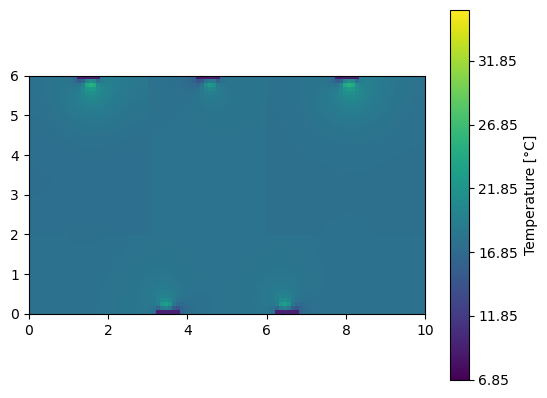

In [249]:
mean_temps3 = []

for i in range(24000 - 1):
    home3.evolve()
    home3.calc_mean_temp()
    mean_temps3.append(home3.avg_temp)
    if i%1000 == 0:
        print(f'Hour no {i}\n')
        print(f'Mean temp {home3.avg_temp - 273}')
        home3.plot_home()
        j = j + 1

In [251]:
mean_temps3 = np.array(mean_temps3) - 273

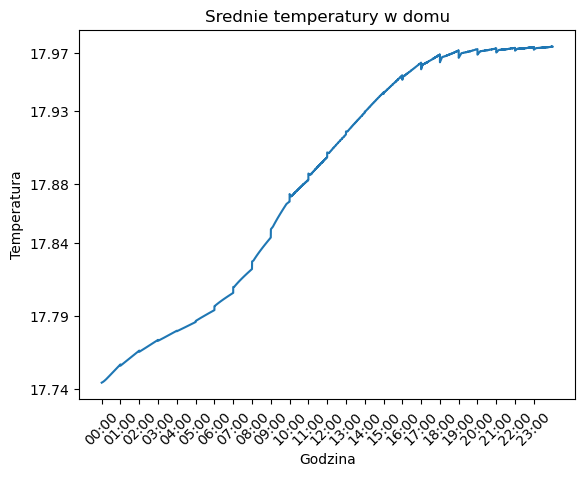

In [253]:
mean_temp_plot(mean_temps3)

In [255]:
home3.energy_used

1377.1328081816941